# Chapter 2 Classification
In the chapter we will using the MNIST dataset,which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.Each image is labeled with the digit it represents.This set has been studied so much that it is often called the "Hello World" of Machine Learning.

In [2]:
>>> from sklearn.datasets import fetch_openml
>>> mnist = fetch_openml('mnist_784', version=1,parser='auto')
>>> mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

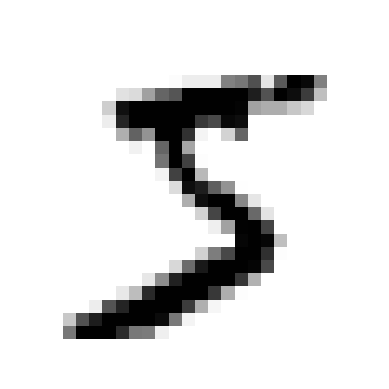

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

Note that the label is a string.Most ML algorithms expectt numbers,so let us cast to integer:

In [10]:
import numpy as np
y = y.astype(np.uint8)


You should always create a test set and set it aside before inspecting the data closely.The MNIST dataset is actually already split into a training set(the first 60,000 iamges) and a test set (the last 10,000 images):

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The rows have been randomly reordered in the shuffled dataset. This helps prevent any bias that might arise from the original order of the data, and it ensures that similar instances are not grouped together.

## Training a Binary Classifier
two classes,5 and not-5

In [12]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)


let us create an SDGClassifier and train it on the whole training set:

In [13]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

c:\Users\qinlo\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# Performance Measures
Evaluating a classifer is often signicicantly trickier than evaluating a regressor,so we will spend a large part of this chapter on this topic.There are many performacne measures avaiable,so grab another coffee and get ready to learn more new concpts and acronyms!
## Measuring Accuracy Using Cross-Validation

A ggod way to evaluate a model is to use cross-validation,
## Implementing Cross-Validation
Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off the shelf.The following code does roughly the same thing as Scikit-Learn's corss_val_score() function,and it prints the same result:

In [16]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    # Convert indices to NumPy arrays
    train_index = np.array(train_index)
    test_index = np.array(test_index)
    
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.9669
0.91625
0.96785


The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class.At each iteration the code creates a clone of te classifier,trains that clone on the training folds,and makes predictions on the test fold.Then it counts the number of correct predictions and outputs the ratio of correct predictions.

Let us use the cross_val_score() function to evaluate our SGDClassifier model.using K-fold cross-validation with three folds.Remember that K-fold cross-validation means spliting the training set into K folds(in this case, three),then making predictions and evaluating them on each fold using a model trained on the remaining folds .

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

Let us look at a very dumb classifier that just classifies every single image in the "not-5" class:

In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
>>> never_5_clf = Never5Classifier()
>>> cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

It has over 90% accuracy! This is simply because only about 10% of the images are 5s,so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally  not the preferred perfromance measure for classifiers, especilly when you are dealing with skewed datasets.(when some classes are much more frequent than others)

# Confusion Matrix
A much better way to evaluate the performance of a classifer is to look at the confusion matrix.The generation idea is to count the number of times instance of class A are classified as Class B.For example, to know the number of times the classifier confused images of 5s and 3s, you would look in the fifth row and third column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the natural targets.You could make predictions on the testset,but let us keep it untouched now.(Remember taht you want to use the test set only at the very end of your project,once you have a classifier that you are ready to launch).Instead ,you can use the cross_val_predict() function.

In [20]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
